# Download data

In [1]:
!pip install yfinance

In [4]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import yfinance as yf

In [5]:
spy_df=yf.download('PTC', interval='1wk')

[*********************100%***********************]  1 of 1 completed


In [6]:
spy_df=spy_df[['Adj Close']].copy()

In [5]:
spy_df.isna().sum()

Adj Close    5
dtype: int64

In [6]:
spy_df.head()

,Adj Close
Date,
1989-12-04,1.822917
1989-12-11,1.822917
1989-12-18,1.875000
1989-12-25,2.187500
1990-01-01,2.265625


In [7]:
spy_df.shape

(1704, 1)

In [8]:
spy_df.isna().sum()

Adj Close    5
dtype: int64

In [10]:
spy_df.dropna(inplace=True)

In [11]:
spy_df.describe()

,Adj Close
count,1699.000000
mean,35.731808
std,30.501542
min,1.692708
25%,15.497500
50%,23.620001
75%,48.565001
max,152.690002


# Analyse Data, find Stationnary

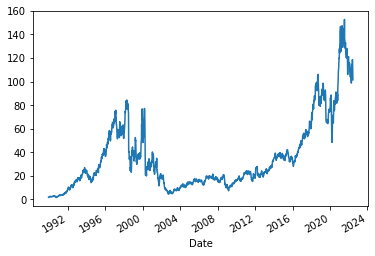

In [12]:
spy_df['Adj Close'].plot();

**As one can see the Timeseries is clearly not stationnary, try to work on the diffs?**

In [11]:
spy_df['diffs']=spy_df['Adj Close'].diff()

In [13]:
spy_df.describe()['diffs']

count    1693.000000
mean        0.059955
std         2.704544
min       -32.500000
25%        -0.680000
50%         0.078125
75%         0.850000
max        15.089996
Name: diffs, dtype: float64

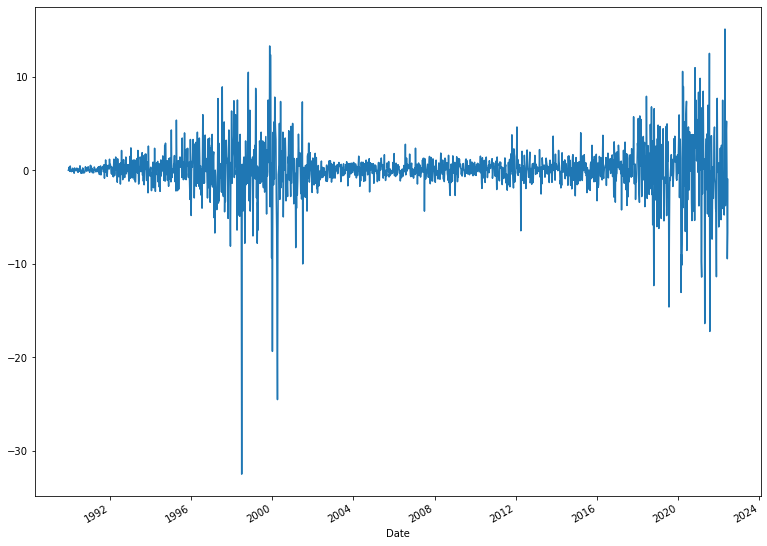

In [15]:
spy_df['diffs'].plot(figsize=(13,10));

**The diffs timeseries is somewhat stationnary, let's work with this**

# Let's build baselines

## The Always predict t-1

In [9]:
spy_df.shape

(1704, 1)

Let's make the last 350 the test set

In [14]:
testset=spy_df['diffs'].iloc[-350:]

In [15]:
trainset=spy_df['diffs'].iloc[:-350]

In [19]:
preds=testset.shift(1)

In [20]:
preds[0]=trainset[-1]

In [21]:
(preds.index==testset.index).all()

True

<AxesSubplot:xlabel='Date'>

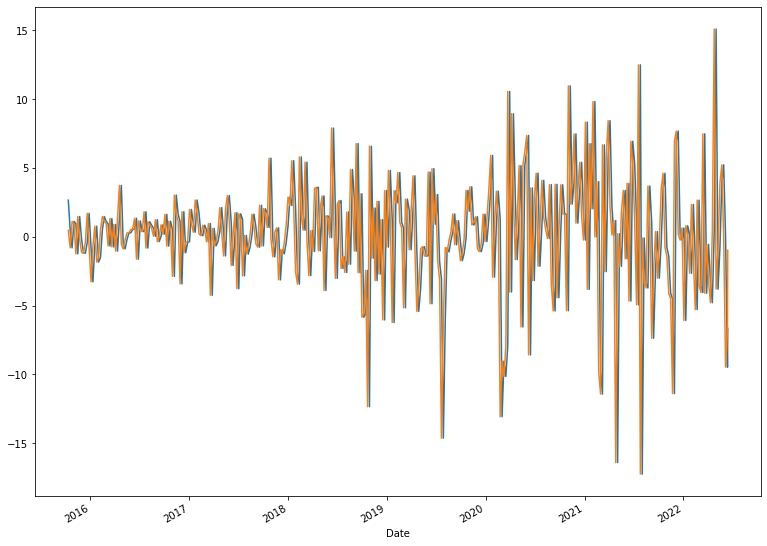

In [22]:
preds.plot(figsize=(13,10))
testset.plot()

In [23]:
from sklearn.metrics import mean_squared_error

In [24]:
rmse_baseline=mean_squared_error(testset,preds,squared=False)
rmse_baseline

5.772245342027639

# Autocorrelation 

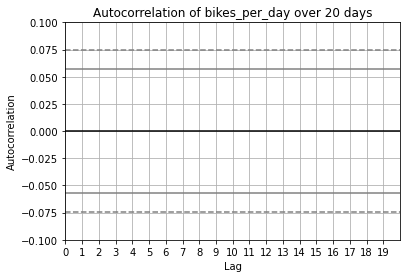

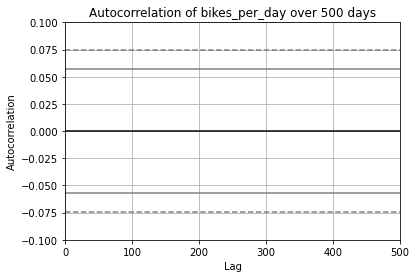

In [57]:
#bikes_per_day = bike_df.resample('d').sum()['Fremont Bridge Total']

plt.figure()
pd.plotting.autocorrelation_plot(trainset)
plt.xlim((0, 20))
plt.ylim((-.1, .1))
plt.xticks(range(20))
plt.title('Autocorrelation of bikes_per_day over 20 days')

plt.figure()
pd.plotting.autocorrelation_plot(trainset)
plt.xlim((0,500))
plt.ylim((-.1, .1))
plt.title('Autocorrelation of bikes_per_day over 500 days');

In [58]:
for i in range(1,30):
    print(i, trainset.autocorr(i))

1 -0.09972114938617423
2 0.060474522398697675
3 -0.04895614738816865
4 -0.03901283686280159
5 0.008058890921263332
6 0.029714831840551226
7 -0.08329711120759872
8 0.057867558902131584
9 -0.013891786976464496
10 -0.019542365856644688
11 0.06264088119109168
12 -0.04335354675691281
13 0.008985048637185588
14 0.024763089712206112
15 0.05441553416368378
16 0.025340728436968763
17 0.035493275256930974
18 -0.020411594946932034
19 -0.03248726020069924
20 0.03340150587047922
21 0.026581834933395904
22 0.03442214484655949
23 0.011275001909711412
24 -0.015327377134139772
25 -0.00983846341483278
26 0.030879374870658702
27 -0.05129707711074985
28 -0.005929237121582162
29 -0.029861063825383338


In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [26]:
trainset[0]

nan

In [27]:
trainset.dropna(inplace=True)

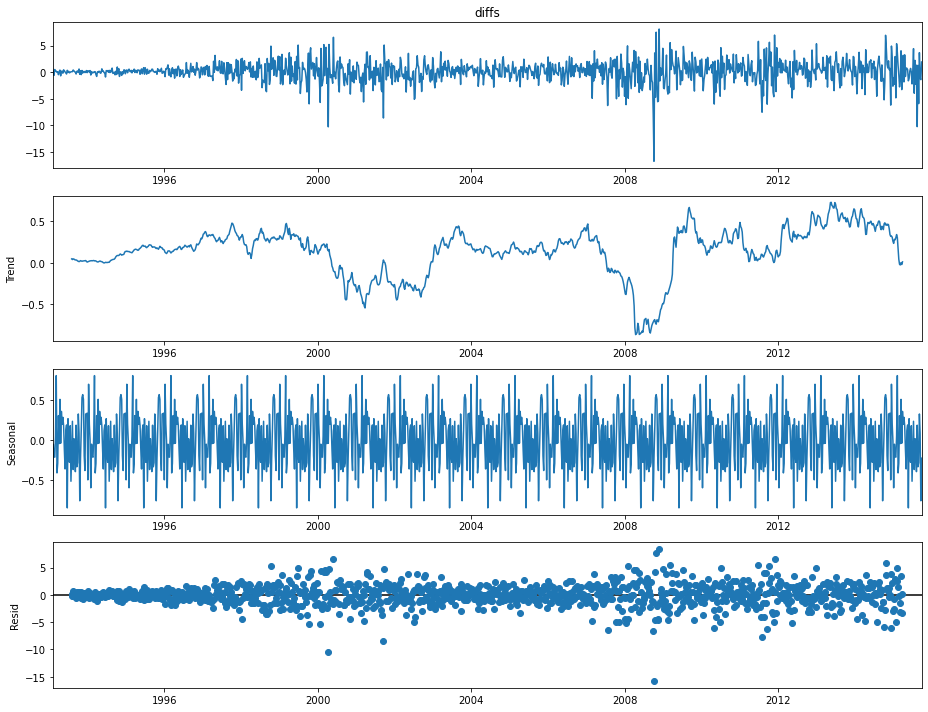

In [64]:
res=seasonal_decompose(trainset)
f=res.plot()
f.set_size_inches((13,10))
f.tight_layout();

In [28]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

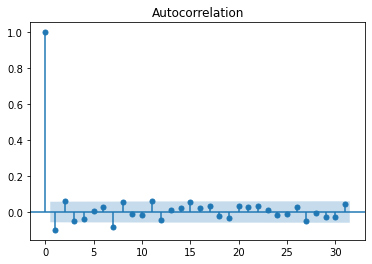

In [66]:
plot_acf(trainset);

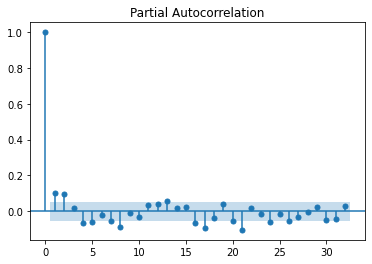

In [29]:
plot_pacf(trainset);

**There is no Autocorrelation what so ever that we can eventually use, it's not so clear the model based on assumptions such as autocorrelation will perform well**

# Arima

In [7]:
from statsmodels.tsa.arima.model import ARIMA

In [16]:
history=trainset.to_list()
predictions=[]
for t in range(len(testset)):
    model=ARIMA(history,order=(2,1,0))
    model_fit=model.fit()
    predictions.append(model_fit.forecast())
    history.append(testset[t])

In [32]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1697
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -4284.698
Date:                Tue, 14 Jun 2022   AIC                           8575.395
Time:                        19:24:57   BIC                           8591.704
Sample:                             0   HQIC                          8581.433
                               - 1697                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6849      0.011    -65.100      0.000      -0.706      -0.664
ar.L2         -0.2983      0.013    -22.935      0.000      -0.324      -0.273
sigma2         9.1571      0.113     81.140      0.000       8.936       9.378
===================================================================================
Ljung-Box (L1) (Q):                   2.94   Jarque-Bera (JB):             13087.51
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                            -0.71
Prob(H) (two-sided):                  0.15   Kurtosis:                        16.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
predictions=[p[0] for p in predictions]

In [18]:
predictions=pd.Series(data=predictions,index=testset.index)

In [35]:
ar_rmse=mean_squared_error(testset,predictions,squared=False)

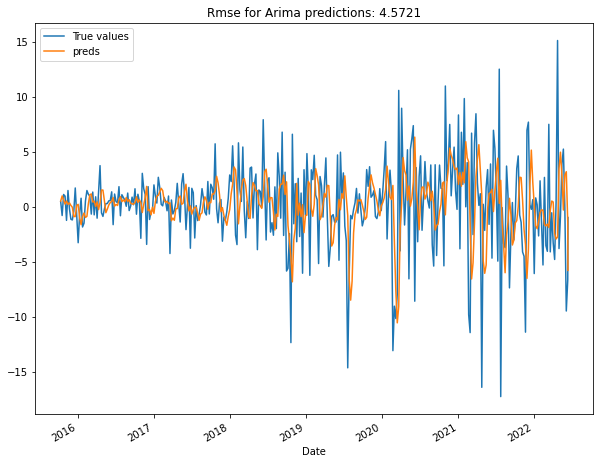

In [36]:
plt.figure(figsize=(10,8))
testset.plot(label='True values')
predictions.plot(label='preds')
plt.title(f'Rmse for Arima predictions: {ar_rmse:.4f}')
plt.legend();

In [37]:
rmse_baseline-ar_rmse

1.2001574911646937

In [39]:
def init_table_1(spy_df, predictions=predictions):
    df = spy_df.iloc[-350:].copy()
    df['Prediction (of diff)'] = predictions.copy()
    df['% change'] = 0.0
    df['Prediction (of % change)'] = 0.0
    df['Recommandation'] = 0
    df['Money end of day'] = 0
    df['Nb of stocks'] = 0
    df['Benefit/day in $'] = 0
    df['cash'] = 0
    return df

def money_end_day_1(df):
    df['Money end of day'][0] = 1000
    for i in range (len(df)):
        df['Prediction (of % change)'][i] = df['Prediction (of diff)'][i]/df['Adj Close'][i]* 100
    
    for i in range (len(df) - 1):
        df['% change'][i+1] = df['diffs'][i+1]/df['Adj Close'][i]* 100
        #if (df['diffs'][i+1] > 0):
        if (df['Prediction (of diff)'][i+1] > 0):
            n_stocks = df['Money end of day'][i]//df['Adj Close'][i]
            cash = df['Money end of day'][i] - n_stocks * df['Adj Close'][i]
            df['Money end of day'][i+1] = n_stocks * df['Adj Close'][i+1] + cash
            print("Buy!", df['Money end of day'][i], df['Money end of day'][i+1])
            df['Nb of stocks'][i] = n_stocks
            df ['cash'][i] = cash
            
        else:
            df['Nb of stocks'][i] = df['Nb of stocks'][i-1]
            df ['cash'][i] = df ['cash'][i-1]
            df['Money end of day'][i+1] = df['Money end of day'][i]
            print("Do not buy!", df['Money end of day'][i], df['Money end of day'][i+1])
            
        df['Benefit/day in $'][i+1] = df['Money end of day'][i+1] - df['Money end of day'][i]

In [42]:

spy_df['diffs']=spy_df['Adj Close'].diff()
df = init_table_1(spy_df, predictions)
money_end_day_1(df)
df

/var/folders/84/w6ykj3cx7gs0nskq7r_6jzk40000gn/T/ipykernel_84876/2332965936.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Money end of day'][0] = 1000
/var/folders/84/w6ykj3cx7gs0nskq7r_6jzk40000gn/T/ipykernel_84876/2332965936.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Prediction (of % change)'][i] = df['Prediction (of diff)'][i]/df['Adj Close'][i]* 100
/var/folders/84/w6ykj3cx7gs0nskq7r_6jzk40000gn/T/ipykernel_84876/2332965936.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas

Buy! 1000 977
Buy! 977 1008
Buy! 1008 1034
Buy! 1034 999
Buy! 999 1040
Buy! 1040 1035
Buy! 1035 1003
Do not buy! 1003 1003
Do not buy! 1003 1003
Do not buy! 1003 1003
Buy! 1003 981
Buy! 981 889
Do not buy! 889 889
Do not buy! 889 889
Do not buy! 889 889
Do not buy! 889 889
Do not buy! 889 889
Do not buy! 889 889
Buy! 889 921
Buy! 921 948
Buy! 948 928
Buy! 928 966
Buy! 966 944
Buy! 944 970
Buy! 970 939
Do not buy! 939 939
Buy! 939 1043
Buy! 1043 1027
Buy! 1027 1002
Buy! 1002 996
Do not buy! 996 996
Do not buy! 996 996
Buy! 996 1010
Buy! 1010 1024
Buy! 1024 1060
Buy! 1060 1015
Buy! 1015 1046
Buy! 1046 1058
Buy! 1058 1067
Buy! 1067 1116
Buy! 1116 1093
Buy! 1093 1122
Buy! 1122 1144
Buy! 1144 1160
Buy! 1160 1161
Buy! 1161 1194
Buy! 1194 1184
Buy! 1184 1185
Buy! 1185 1208
Buy! 1208 1212
Buy! 1212 1256
Buy! 1256 1237
Buy! 1237 1267
Buy! 1267 1280
Buy! 1280 1202
Do not buy! 1202 1202
Buy! 1202 1242
Buy! 1242 1269
Buy! 1269 1183
Do not buy! 1183 1183
Do not buy! 1183 1183
Do not buy! 1183 1183


,Adj Close,diffs,Prediction (of diff),% change,Prediction (of % change),Recommandation,Money end of day,Nb of stocks,Benefit/day in $,cash
Date,,,,,,,,,,
2015-10-12,35.130001,0.460003,0.515010,0.000000,1.466011,0,1000,28,0,16
2015-10-19,34.330002,-0.799999,0.985259,-2.277254,2.869965,0,977,28,-23,15
2015-10-26,35.439999,1.109997,0.628294,3.233314,1.772839,0,1008,28,31,15
2015-11-02,36.400002,0.960003,0.237843,2.708812,0.653416,0,1034,28,26,14
2015-11-09,35.160000,-1.240002,0.518532,-3.406598,1.474778,0,999,28,-35,14
...,...,...,...,...,...,...,...,...,...,...
2022-05-23,118.650002,5.230003,-0.300255,4.611183,-0.253060,0,2510,21,0,18
2022-05-30,118.559998,-0.090004,2.866828,-0.075857,2.418040,0,2508,21,-2,18
2022-06-06,109.089996,-9.470001,3.182226,-7.987518,2.917065,0,2309,21,-199,18


In [55]:
original_price = "Adj Close"
original_diffs = "Original diffs"
original_persent = "Original % change"
prediction_price = "Prediction (price)"
prediction_diffs = "Prediction (diffs)"
prediction_persent = "Prediction (% change)"
prediction_recommendations = "Prediction recommendations"
money_at_end_day = "money_at_end_day"
money_cash = "money_cash"
number_stocks = "number_stocks"
money_day_benefits = "money_day_benefits"
type_predictions_list = ["type_price", "type_diffs", "type_persents"]

start_capital = 1000

def init_table(date_price=date_price, predictions=predictions, predictions_type=type_predictions_list[0]):
    df = date_price.copy()
    df[original_diffs] = df[original_price].diff().copy()
    df[original_persent] = 0.0
    
    df[prediction_price] = 0.0
    df[prediction_diffs] = 0.0
    df[prediction_persent] = 0.0
    df[prediction_recommendations] = 0.0
    
    df[money_at_end_day] = 0.0
    df[money_cash] = 0.0
    df[number_stocks] = 0
    df[money_day_benefits] = 0.0

    init_table_predictions(df=df, predictions=predictions, predictions_type=predictions_type)

    return df

def init_table_predictions(df, predictions, predictions_type):
    if predictions_type == type_predictions_list[0]:
        df[prediction_price] = predictions.copy()
        df[prediction_diffs] = df[prediction_price].diff()
        calculate_persent_by_price(df)
        
    elif predictions_type == type_predictions_list[1]:
        df[prediction_price] = 0.0
        df[prediction_diffs] = predictions.copy()
        calculate_persent_by_price(df)
        
    elif predictions_type == type_predictions_list[2]:
        df[prediction_price] = 0.0
        calculate_diff_by_persent(df)
        df[prediction_persent] = predictions.copy()   
       
    calculate_recommendation(df)
    return df

def calculate_persent_by_price(df):
    for i in range (len(df)):
        df[prediction_persent][i] = df[prediction_diffs][i]/df[original_price][i]* 100

def calculate_diff_by_persent(df):
    for i in range (len(df)):
        df[prediction_diffs][i] = df[prediction_persent][i]*df[original_price][i]/ 100
        
def calculate_recommendation(df):
    df[prediction_recommendations] = df[prediction_diffs] > 0    

def calculate_money_end_day(df):
    df[money_at_end_day][0] = start_capital    
    for i in range (len(df) - 1):
        df[original_persent][i+1] = df[original_diffs][i+1]/df[original_price][i]* 100
        #if (df['diffs'][i+1] > 0):
        if (df[prediction_diffs][i+1] > 0):
            n_stocks = df[money_at_end_day][i]//df[original_price][i]
            cash = df[money_at_end_day][i] - n_stocks * df[original_price][i]
            df[money_at_end_day][i+1] = n_stocks * df[original_price][i+1] + cash
            print("Buy!", df[money_at_end_day][i], df[money_at_end_day][i+1])
            df[number_stocks][i] = n_stocks
            df [money_cash][i] = cash
            
        else:
            df[number_stocks][i] = df[number_stocks][i-1]
            df [money_cash][i] = df [money_cash][i-1]
            df[money_at_end_day][i+1] = df[money_at_end_day][i]
            print("Do not buy!", df[money_at_end_day][i], df[money_at_end_day][i+1])
            
        df[money_day_benefits][i+1] = df[money_at_end_day][i+1] - df[money_at_end_day][i]

In [62]:
spy_df=yf.download('PTC', interval='1wk')
spy_df=spy_df[['Adj Close']].copy()
date_price = spy_df.iloc[-350:].copy()
#trainset=spy_df['Adj Close'].diff().iloc[:-350]
#predictions[0]=trainset[-1]



df = init_table(date_price=date_price, predictions=predictions, predictions_type=type_predictions_list[1])
calculate_money_end_day(df)
df

[*********************100%***********************]  1 of 1 completed
Buy! 1000.0 977.6000213623047
Buy! 977.6000213623047 1008.679931640625
Buy! 1008.679931640625 1035.5600128173828
Buy! 1035.5600128173828 1000.8399658203125
Buy! 1000.8399658203125 1042.0
Buy! 1042.0 1037.2399444580078
Buy! 1037.2399444580078 1005.3199615478516
Do not buy! 1005.3199615478516 1005.3199615478516
Do not buy! 1005.3199615478516 1005.3199615478516
Do not buy! 1005.3199615478516 1005.3199615478516
Buy! 1005.3199615478516 983.4799957275391
Buy! 983.4799957275391 891.9199829101562
Do not buy! 891.9199829101562 891.9199829101562
Do not buy! 891.9199829101562 891.9199829101562
Do not buy! 891.9199829101562 891.9199829101562
Do not buy! 891.9199829101562 891.9199829101562
Do not buy! 891.9199829101562 891.9199829101562
Do not buy! 891.9199829101562 891.9199829101562
Buy! 891.9199829101562 924.6899585723877
Buy! 924.6899585723877 952.2399806976318
Buy! 952.2399806976318 932.8099784851074
Buy! 932.8099784851074 971

/var/folders/84/w6ykj3cx7gs0nskq7r_6jzk40000gn/T/ipykernel_84876/1727591173.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[prediction_persent][i] = df[prediction_diffs][i]/df[original_price][i]* 100
/var/folders/84/w6ykj3cx7gs0nskq7r_6jzk40000gn/T/ipykernel_84876/1727591173.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[money_at_end_day][0] = start_capital
/var/folders/84/w6ykj3cx7gs0nskq7r_6jzk40000gn/T/ipykernel_84876/1727591173.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

Buy! 1643.4402256011963 1671.1602191925049
Buy! 1671.1602191925049 1742.350206375122
Buy! 1742.350206375122 1866.460283279419
Buy! 1866.460283279419 1804.9302768707275
Buy! 1804.9302768707275 1824.0401935577393
Buy! 1824.0401935577393 1893.7601871490479
Buy! 1893.7601871490479 1920.4302768707275
Buy! 1920.4302768707275 1645.960283279419
Do not buy! 1645.960283279419 1645.960283279419
Do not buy! 1645.960283279419 1645.960283279419
Do not buy! 1645.960283279419 1645.960283279419
Do not buy! 1645.960283279419 1645.960283279419
Do not buy! 1645.960283279419 1645.960283279419
Buy! 1645.960283279419 1905.2202434539795
Buy! 1905.2202434539795 1984.1003894805908
Buy! 1984.1003894805908 1935.960283279419
Buy! 1935.960283279419 1975.98020362854
Buy! 1975.98020362854 2125.9103717803955
Buy! 2125.9103717803955 1935.960283279419
Buy! 1935.960283279419 2087.050256729126
Buy! 2087.050256729126 2265.98020362854
Buy! 2265.98020362854 2479.4202213287354
Buy! 2479.4202213287354 2230.600389480591
Buy! 22

,Adj Close,Original diffs,Original % change,Prediction (price),Prediction (diffs),Prediction (% change),Prediction recommendations,money_at_end_day,money_cash,number_stocks,money_day_benefits
Date,,,,,,,,,,,
2015-10-12,35.130001,NaN,0.000000,0.0,2.660000,7.571875,True,1000.000000,16.359970,28,0.000000
2015-10-19,34.330002,-0.799999,-2.277254,0.0,0.985259,2.869965,True,977.600021,16.359970,28,-22.399979
2015-10-26,35.439999,1.109997,3.233314,0.0,0.628294,1.772839,True,1008.679932,16.359970,28,31.079910
2015-11-02,36.400002,0.960003,2.708812,0.0,0.237843,0.653416,True,1035.560013,16.359970,28,26.880081
2015-11-09,35.160000,-1.240002,-3.406598,0.0,0.518532,1.474778,True,1000.839966,16.359970,28,-34.720047
...,...,...,...,...,...,...,...,...,...,...,...
2022-05-23,118.650002,5.230003,4.611183,0.0,-0.300255,-0.253060,False,2639.850580,29.550547,22,0.000000
2022-05-30,118.559998,-0.090004,-0.075857,0.0,2.866828,2.418040,True,2637.870493,29.550547,22,-1.980087
2022-06-06,109.089996,-9.470001,-7.987518,0.0,3.182226,2.917065,True,2429.530466,29.550547,22,-208.340027


In [63]:
from sklearn.metrics import mean_squared_error
def summary_table(df):
    print(f"Beginning money: {df[money_at_end_day][0]}")
    print(f"End money      : {df[money_at_end_day][-1]}")
    print(f"Pct of return  : {df[money_at_end_day][-1]/df[money_at_end_day][0] * 100 - 100}")
    print(f"Std deviation on daily returns : {df[money_day_benefits].std()}")
    # Just for rmse calculation
    df[original_diffs][0] = 0
    rmse = mean_squared_error(df[original_diffs], df[prediction_diffs],squared=False)
    print(f"RMSE           : {rmse}")
    true_preds = 0
    for i in range(len(df) - 1):
        if (df[prediction_diffs][i] > 0 and df[original_diffs][i+1] > 0) or \
           (df[prediction_diffs][i] < 0 and df[original_diffs][i+1] < 0):
                true_preds += 1
            
    print(f"Accuracy       : {true_preds/len(df)}")

In [64]:
summary_table(df)

Beginning money: 1000.0
End money      : 2429.530466079712
Pct of return  : 142.9530466079712
Std deviation on daily returns : 71.89419087824288
RMSE           : 4.611347443189303
Accuracy       : 0.5342857142857143


/var/folders/84/w6ykj3cx7gs0nskq7r_6jzk40000gn/T/ipykernel_84876/370990874.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[original_diffs][0] = 0
